In [1]:
#import sys
#sys.path.append('/Users/huangxingyue/Desktop/NYU MFE/12 Capstone')
import numpy as np
import pandas as pd
import math
from Pricing.MC_simulation import *
from Fitter.fitter import Fitter
from Pricing.BS import *
from matplotlib import pyplot as plt

** Take data of 5Y tenor and 10Y expiry as an example **

In [2]:
fitter=Fitter('market_data.xlsx')
results=fitter.calibration() #Hagan lognormal implementation
ivols=fitter.ivol_SABR(results['alpha'],results['beta'],results['rho'],results['nu'])
params=results['params']

factors=params.loc[13,:][2:]
vols=ivols.loc[13,:]
print ('params:\n', factors)
print ('ivols:\n', vols)

('params:\n', F        0.033460
alpha    0.020476
beta     0.311017
rho     -0.102919
nu       0.311203
Name: 13, dtype: float64)
('ivols:\n', tenor      5.000000
expiry    10.000000
F          0.033460
-150       0.311059
-100       0.274397
-50        0.248384
-25        0.238508
0          0.230400
25         0.223851
50         0.218662
100        0.211611
150        0.207853
Name: 13, dtype: float64)


### MC Euler scheme

#### case1: $\nu=0$ for $\rho=\{0,0.8,-0.8\}$ and $\beta=\{0,0.3,0.5,0.7,1\}$ with $n_{sim}=100000, n_{step}=40$

In [3]:
results=[]
for rho in [0,0.8,-0.8]:
    for beta in [0,0.3,0.5,0.7,1]:
        res=minimize(objfunc_atm,0,(beta,rho,0,vols['F'],10,vols[0]))
        result=[res.x[0],beta,rho,0]
        forwards1=simulateSABRMonteCarloEuler(100000,40,10,vols['F'],res.x[0],beta,rho,0)
        #forwards2=simulateSABRMonteCarloMilstein(100000,40, 10, vols['F'],0.0071957323083426811,0,0,0.25)
        MC_price=[]
        for K_spread in vols.index.tolist()[3:]:
            option=[max(0, item-(vols['F']+K_spread/10000.)) for item in forwards1]
            MC_price.append(sum(option)/len(option))
        for counter, K_spread in enumerate(vols.index.tolist()[3:]):
            result.append(find_ivol(MC_price[counter],vols['F'],vols['F']+K_spread/10000.,10))
        result.append(np.std(forwards1))
        results.append(result)
results=pd.DataFrame(results,columns=['alpha','beta','rho','nu','-150','-100','-50','-25','0','25','50','100','150','MC standard error'])
print (results)

       alpha  beta  rho  nu    -150    -100     -50     -25       0      25  \
0   0.007549   0.0  0.0   0  0.3124  0.2774  0.2514  0.2407  0.2312  0.2226   
1   0.021138   0.3  0.0   0  0.2833  0.2611  0.2439  0.2367  0.2301  0.2242   
2   0.041916   0.5  0.0   0  0.2644  0.2496  0.2381  0.2332  0.2287  0.2246   
3   0.082981   0.7  0.0   0  0.2505  0.2422  0.2355  0.2325  0.2297  0.2271   
4   0.230400   1.0  0.0   0  0.2338  0.2335  0.2330  0.2328  0.2327  0.2325   
5   0.007549   0.0  0.8   0  0.3108  0.2762  0.2505  0.2399  0.2303  0.2217   
6   0.021138   0.3  0.8   0  0.2878  0.2641  0.2462  0.2387  0.2319  0.2258   
7   0.041916   0.5  0.8   0  0.2704  0.2540  0.2414  0.2360  0.2312  0.2268   
8   0.082981   0.7  0.8   0  0.2593  0.2482  0.2399  0.2365  0.2334  0.2305   
9   0.230400   1.0  0.8   0  0.2305  0.2315  0.2316  0.2315  0.2314  0.2312   
10  0.007549   0.0 -0.8   0  0.3098  0.2757  0.2503  0.2399  0.2305  0.2220   
11  0.021138   0.3 -0.8   0  0.2857  0.2630  0.2457 

#### case2: $\rho=0$ for $\nu=\{0.25,0.5\}$ and $\beta=\{0,0.3,0.5,0.7,1\}$ with $n_{sim}=100000, n_{step}=40$

In [4]:
results=[]
for nu in [0.25,0.5]:
    for beta in [0,0.3,0.5,0.7,1]:
        res=minimize(objfunc_atm,0,(beta,0,nu,vols['F'],10,vols[0]))
        result=[res.x[0],beta,0,nu]
        forwards1=simulateSABRMonteCarloEuler(100000,40,10,vols['F'],res.x[0],beta,0,nu)
        MC_price=[]
        for K_spread in vols.index.tolist()[3:]:
            option=[max(0, item-(vols['F']+K_spread/10000.)) for item in forwards1]
            MC_price.append(sum(option)/len(option))
        for counter, K_spread in enumerate(vols.index.tolist()[3:]):
            result.append(find_ivol(MC_price[counter],vols['F'],vols['F']+K_spread/10000.,10))
        result.append(np.std(forwards1))
        results.append(result)
results=pd.DataFrame(results,columns=['alpha','beta','rho','nu','-150','-100','-50','-25','0','25','50','100','150','MC standard error'])
print (results)

      alpha  beta  rho    nu    -150    -100     -50     -25       0      25  \
0  0.007196   0.0    0  0.25  0.3232  0.2812  0.2518  0.2403  0.2306  0.2223   
1  0.020121   0.3    0  0.25  0.2802  0.2547  0.2364  0.2292  0.2232  0.2181   
2  0.039871   0.5    0  0.25  0.2754  0.2533  0.2379  0.2322  0.2274  0.2235   
3  0.078895   0.7    0  0.25  0.2593  0.2431  0.2325  0.2287  0.2258  0.2235   
4  0.218994   1.0    0  0.25  0.2589  0.2458  0.2390  0.2371  0.2360  0.2356   
5  0.006303   0.0    0  0.50  0.3474  0.2901  0.2518  0.2381  0.2278  0.2204   
6  0.017573   0.3    0  0.50  0.2824  0.2454  0.2201  0.2114  0.2052  0.2011   
7  0.034770   0.5    0  0.50  0.2775  0.2432  0.2206  0.2134  0.2085  0.2057   
8  0.068733   0.7    0  0.50  0.2632  0.2341  0.2152  0.2094  0.2059  0.2042   
9  0.190676   1.0    0  0.50     NaN     NaN     NaN     NaN     NaN     NaN   

       50     100     150  MC standard error  
0  0.2152  0.2041  0.1962       2.664241e-02  
1  0.2138  0.2073  0.2029

#### case3: $\rho=\{0.8,-0.8\}$ for $\nu=\{0.25,0.5\}$ and $\beta=\{0,0.3,0.5,0.7,1\}$ with $n_{sim}=100000, n_{step}=40$

In [5]:
results=[]
for rho in [0.8,-0.8]:    
    for nu in [0.25,0.5]:
        for beta in [0,0.3,0.5,0.7,1]:
            res=minimize(objfunc_atm,0,(beta,rho,nu,vols['F'],10,vols[0]))
            result=[res.x[0],beta,rho,nu]
            forwards1=simulateSABRMonteCarloEuler(100000,40,10,vols['F'],res.x[0],beta,rho,nu)
            MC_price=[]
            for K_spread in vols.index.tolist()[3:]:
                option=[max(0, item-(vols['F']+K_spread/10000.)) for item in forwards1]
                MC_price.append(sum(option)/len(option))
            for counter, K_spread in enumerate(vols.index.tolist()[3:]):
                result.append(find_ivol(MC_price[counter],vols['F'],vols['F']+K_spread/10000.,10))
            result.append(np.std(forwards1))
            results.append(result)
results=pd.DataFrame(results,columns=['alpha','beta','rho','nu','-150','-100','-50','-25','0','25','50','100','150','MC standard error'])
print (results)

       alpha  beta  rho    nu    -150    -100     -50     -25       0      25  \
0   0.007534   0.0  0.8  0.25  0.2542  0.2424  0.2359  0.2337  0.2320  0.2306   
1   0.020441   0.3  0.8  0.25  0.2282  0.2274  0.2286  0.2295  0.2306  0.2317   
2   0.039712   0.5  0.8  0.25  0.2235  0.2259  0.2308  0.2335  0.2361  0.2387   
3   0.077090   0.7  0.8  0.25  0.1964  0.2099  0.2218  0.2271  0.2321  0.2368   
4   0.208276   1.0  0.8  0.25  0.5196  0.4646  0.4472  0.4448  0.4448  0.4461   
5   0.007490   0.0  0.8  0.50  0.2440  0.2295  0.2305  0.2337  0.2375  0.2416   
6   0.019752   0.3  0.8  0.50  0.2533  0.2374  0.2413  0.2466  0.2526  0.2588   
7   0.037764   0.5  0.8  0.50  0.2495  0.2356  0.2433  0.2507  0.2586  0.2665   
8   0.072296   0.7  0.8  0.50  0.2827  0.2615  0.2680  0.2763  0.2854  0.2946   
9   0.191954   1.0  0.8  0.50     NaN     NaN     NaN     NaN     NaN     NaN   
10  0.007534   0.0 -0.8  0.25  0.3781  0.3155  0.2689  0.2494  0.2320  0.2162   
11  0.021841   0.3 -0.8  0.2

#### case4: MC with SABR parameters calibrated, $n_{sim}=100000, n_{step}=40$

('MC standard error:', 0.025612210127479215)


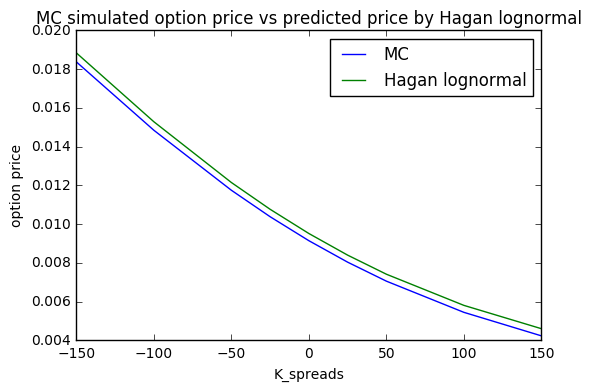

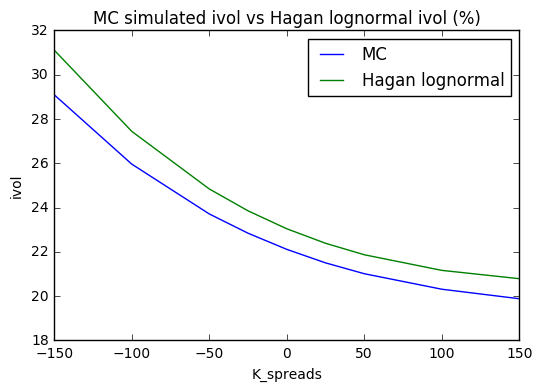

In [6]:
forwards1=simulateSABRMonteCarloEuler(100000,40,10,vols['F'],factors['alpha'],factors['beta'],factors['rho'],factors['nu'])
print ('MC standard error:', np.std(forwards1))

#plot MC simulated option prices against BS prices with Hagan ivol
p1=[] #MC simulated option price
p2=[] #BS price by Hagan ivol
for K_spread in vols.index.tolist()[3:]:
    option=[max(0, item-(vols['F']+K_spread/10000.)) for item in forwards1]
    p1.append(sum(option)/len(option))
    p2.append(black(vols['F'],(vols['F']+K_spread/10000.),10,vols[K_spread],1))  
plt.plot(vols.index.tolist()[3:],p1,label='MC')
plt.plot(vols.index.tolist()[3:],p2,label='Hagan lognormal')
plt.title('MC simulated option price vs predicted price by Hagan lognormal')
plt.xlabel('K_spreads')
plt.ylabel('option price')
plt.legend()
plt.show()

#plot MC simulated ivols against Hagan ivols
ivols_hagan=vols.values[3:] #Hagan ivol
ivols_MC=[] #MC simulated ivol
for counter, K_spread in enumerate(vols.index.tolist()[3:]):
    ivols_MC.append(find_ivol(p1[counter],vols['F'],vols['F']+K_spread/10000.,10))
plt.plot(vols.index.tolist()[3:],[item*100 for item in ivols_MC],label='MC')
plt.plot(vols.index.tolist()[3:],[item*100 for item in ivols_hagan],label='Hagan lognormal')
plt.title('MC simulated ivol vs Hagan lognormal ivol (%)')
plt.xlabel('K_spreads')
plt.ylabel('ivol')
plt.legend()
plt.show()

### MC Milstein scheme

#### case5: $\rho=0,\nu=0.25$ for $\beta=\{0,0.3,0.5,0.7,1\}$ with $n_{sim}=100000, n_{step}=40$

In [7]:
results=[]
for beta in [0,0.3,0.5,0.7,1]:
    res=minimize(objfunc_atm,0,(beta,0,0.25,vols['F'],10,vols[0]))
    result=[res.x[0],beta,rho,nu]
    forwards2=simulateSABRMonteCarloMilstein(100000,40,10,vols['F'],res.x[0],beta,0,0.25)
    MC_price=[]
    for K_spread in vols.index.tolist()[3:]:
        option=[max(0, item-(vols['F']+K_spread/10000.)) for item in forwards2]
        MC_price.append(sum(option)/len(option))
    for counter, K_spread in enumerate(vols.index.tolist()[3:]):
        result.append(find_ivol(MC_price[counter],vols['F'],vols['F']+K_spread/10000.,10))
    result.append(np.std(forwards2))
    results.append(result)
results=pd.DataFrame(results,columns=['alpha','beta','rho','nu','-150','-100','-50','-25','0','25','50','100','150','MC standard error'])
print (results)

      alpha  beta  rho   nu    -150    -100     -50     -25       0      25  \
0  0.007196   0.0 -0.8  0.5  0.3264  0.2837  0.2535  0.2418  0.2318  0.2234   
1  0.020121   0.3 -0.8  0.5  0.2843  0.2579  0.2391  0.2318  0.2256  0.2202   
2  0.039871   0.5 -0.8  0.5  0.2713  0.2503  0.2359  0.2304  0.2259  0.2222   
3  0.078895   0.7 -0.8  0.5  0.2499  0.2364  0.2274  0.2242  0.2217  0.2198   
4  0.218994   1.0 -0.8  0.5  0.2345  0.2277  0.2245  0.2239  0.2237  0.2240   

       50     100     150  MC standard error  
0  0.2162  0.2050  0.1970           0.027019  
1  0.2157  0.2088  0.2041           0.025520  
2  0.2192  0.2149  0.2122           0.027363  
3  0.2183  0.2166  0.2161           0.028955  
4  0.2247  0.2267  0.2293           0.446469  
